# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [8]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from chxanalys.chx_xpcs_xsvs_jupyter_V1 import *

In [9]:
Javascript( '''
            var nb = IPython.notebook;
            var kernel = IPython.notebook.kernel;
            var command = "NFP = '" + nb.base_url + nb.notebook_path + "'";        
            kernel.execute(command);
            ''' )


<IPython.core.display.Javascript object>

In [10]:
print( 'The current running pipeline is: %s' %NFP)

The current running pipeline is: /user/sutton/analysis/2017_2/sutton/XPCS_Single_2017_V4_template.ipynb


In [11]:
#%reset -f -s dhist in out array

## Control Runs Here

In [12]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_waxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
                           # gi_waxs define a simple box-shaped ROI 
force_compress = False #True   #force to compress data 
bin_frame = False   #generally make bin_frame as False
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall =  False #True   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time =  True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time =  True #False    #run  two-time
run_four_time = False #True #False   #run  four-time
run_xsvs=  False #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 1 #the intested single qth             
use_sqnorm = True    #if True, use sq to normalize intensity
use_imgsum_norm= True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_June17'     #for pdf report name
run_dose = True  #run dose_depend analysis

if scat_geometry == 'gi_saxs':run_xsvs= False;use_sqnorm=False
if scat_geometry == 'gi_waxs':use_sqnorm = False;
    

In [13]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None; lag_steps = None 

## Make a directory for saving results

In [14]:
CYCLE= '2017_2'  #change clycle here
path = '/XF11ID/analysis/%s/masks/'%CYCLE


username =  getpass.getuser()
#username = 'commissioning'
 
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_2/sutton/Results/
/XF11ID/analysis/2017_2/sutton/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [48]:

uid = '0556c4'

uid= 'd22755' # (scan num: 23715) (Measurement: T3 xpcs test - 10 kframes at 200Hz, att 1 )
uid = 'def0b4'# (scan num: 23722) (Measurement: SBA 15 xpcs test - 10 k frames at 200Hz, att 1 )

uid='04ec3a' # (scan num: 23724) (Measurement: SBA 15 xpcs test - 10 k frames at 200Hz, att 0.1 )


uid = 'b3c73f' # (scan num: 23734) (Measurement: T4 xpcs test - 10 frames at 200Hz, att 1 )
#file name pattern: f86996f-4dff-48df-8a8e_$id

uid = 'a2c72c' # (scan num: 23737) (Measurement: T4 xpcs test - 10 k frames at 200Hz, att 0.1 )
uid = '838ce5' # (scan num: 23741) (Measurement: phytospherix 32.5 xpcs test - 10 k frames at 200Hz, att 1 )
uid = 'aa8fac00' # (scan num: 23743) (Measurement: phytospherix 32.5 xpcs test - 0 k frames at 20Hz, att 0.1 )
uid = '486cb2' # (scan num: 23751) (Measurement: T3 in sample chamber xpcs test - 10 k frames at 200Hz, att 1 )
uid = '31774b' # (scan num: 23753) (Measurement: T3 in sample chamber xpcs test - 10 k frames at 200Hz, att 0.1 )
uid = 'd934b2' # (scan num: 23754) (Measurement: T3 in sample chamber xpcs -250 frams acq=1 exp=0.1 att 0.1 )
uid='571182'# (scan num: 23755) (Measurement: T3 in sample chamber xpcs -250 frams acq=1 exp=0.1 att 0.1_repeat )
uid='253b3d'#(scan num: 23756) (Measurement: T3 in sample chamber xpcs -1800 frams acq=1.34ms exp=1.34ms att 1 )

uid = '2aa3ea' #(scan num: 23757) (Measurement: T3 in sample chamber xpcs -2500frams acq=0.1s exp=0.01s att 0.1 )

uid = '81c836' #(scan num: 23758) (Measurement: T3 in sample chamber xpcs -250frames acq=0.01s exp=0.01s att 0.1 )
uid='1123bf' #(scan num: 23759) (Measurement: T3 in sample chamber xpcs -2500frams acq=0.1s exp=0.01s att 0.1 )
uid='64e703'#(scan num: 23761) (Measurement: T3 in sample chamber xpcs -2500frams acq=0.5s exp=0.01s att 0.1 )
uid='97f996' #(scan num: 23762) (Measurement: T3 in sample chamber xpcs -2500frams acq=0.1s exp=0.01s att 0.1 )
uid='b0edfc'#(scan num: 23764) (Measurement: T3 in sample chamber xpcs -1500frams acq=0.01s exp=0.01s att 0.1 )
uid='00e9ca'#(scan num: 23765) (Measurement: T3 in sample chamber xpcs -1500frams acq=0.01s exp=0.01s att 0.1 )
uid='6b804a' #(scan num: 23766) (Measurement: T3 in sample chamber xpcs -1500frams acq=0.01s exp=0.01s att 0.1 )
uid='33c50a'#(scan num: 23767) (Measurement: T3 in sample chamber xpcs -300frams acq=0.002s exp=0.002s att 1 )
uid='dfdf04'#(scan num: 23768) (Measurement: T3 in sample chamber xpcs -300frames acq=0.002s exp=0.002s att 1 )
uid='ce1abf'#(scan num: 23769) (Measurement: T3 in sample chamber xpcs -300frames acq=0.002s exp=0.002s att 1 )
uid='f8f3d5'#scan num: 23770) (Measurement: T3 in sample chamber xpcs -300frames acq=0.002s exp=0.002s att 1 )
uid='8637a6' #(scan num: 23771) (Measurement: T3 in sample chamber xpcs -300frames acq=0.002s exp=0.002s att 1 )
uid='d7e162'# (scan num: 23779) (Measurement: T3 SBA15 in sample chamber xpcs -1000frames acq=0.002s exp=0.002s att 1 )
uid='c06edc'# (scan num: 23782) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.02s exp=0.002s att .1
uid='9b45c2'# (scan num: 23783) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.02s exp=0.002s att .1 )
uid='e70917'# (scan num: 23784) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.02s att .1 )
uid='22c1dd'# (scan num: 23786) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.02s att .1 )
uid='581da4'# (scan num: 23787) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.01s att .1 )
uid='0decf6'# (scan num: 23788) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.01s att .1 )
uid='372d72'# (scan num: 23789) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.1s att .01 )
uid='e01054'#(scan num: 23790) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.01s att .1 )
uid='170bf2'# (scan num: 23791) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.1s att .01 )
uid='3b06c8'#(scan num: 23792) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.5s att .001 )
uid='a052b6'#(scan num: 23711) (Measurement: T3 SBA 15 xpcs test - 10 kframes at 200Hz, att 0.1 )
uid='6a47e1'#(scan num: 23793) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.5s att .001 )
uid='6a47e1'# (scan num: 23793) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.5s att .001 )
uid='7c6a7e'#(scan num: 23795) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.5s att .001 )
uid='baa6a2'#(scan num: 23796) (Measurement: T3 SBA15 in cryostat xpcs -5000frames acq=0.00134s exp=0.00134s att 1 )
uid='7eaefa'#(scan num: 23797) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.5s att .001 )
uid='61dc9f'#(scan num: 23798) (Measurement: T3 SBA15 in cryostat xpcs -3000frames acq=0.5s exp=0.5s att .001 )
uid='060ce7'#(scan num: 23799) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.5s att .001 )
uid='e0ce50'#(scan num: 23800) (Measurement: T3 SBA15 in cryostat xpcs -3000frames acq=0.1s exp=0.1s att .005 )
uid='fd5322'#(scan num: 23801) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.00134s exp=0.00134s att 1 )
#(empty) uid='ec16ce'#(scan num: 23802) (Measurement: T3 SBA15 in cryostat xpcs -3000frames acq=0.1s exp=0.1s att .005 )
uid='856e42'#(scan num: 23803) (Measurement: T3 SBA15 in cryostat xpcs -3000frames acq=0.1s exp=0.1s att .005 )
uid='37bf07'#(scan num: 23804) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.00134s exp=0.00134s att 1 )
uid='634829'#(scan num: 23805) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.00134s exp=0.00134s att 1 )
uid='050501'#(scan num: 23806) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.1s exp=0.1s att .005 )
uid='7ceef4'#(scan num: 23808) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.5s exp=0.5s att .002 )
uid='0f1ea03e'#(scan num: 23807) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.1s exp=0.1s att .005 )
uid='634829'#(scan num: 23805) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.00134s exp=0.00134s att 1 )
uid='fceb08'#(scan num: 23810) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.5s exp=0.5s att .002 )
uid='26a4a8'#(scan num: 23811) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.00134s exp=0.00134s att 1 )
uid='63d3a3'#(scan num: 23812) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.1s exp=0.1s att .005 )

uid='56ba9a'#(scan num: 23830) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.00134s exp=0.00134s att 1 )
uid='9eebab'#(scan num: 23829) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.5s exp=0.5s att .002 )
uid='c72a69'#(scan num: 23828) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.00134s exp=0.00134s att 1 )
uid='4254d4'#(scan num: 23827) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.5s exp=0.5s att .002 )
uid='3b1e79'#(scan num: 23826) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.00134s exp=0.00134s att 1 )
#uid='ce5107'#(scan num: 23825) (Measurement: T3 SBA15 in cryostat xpcs -2000frames acq=0.5s exp=0.5s att .002 )




In [49]:
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))
#start_time, stop_time = '2017-2-24  12:23:00', '2017-2-24  13:42:00' 
#sids, uids, fuids  = find_uids(start_time, stop_time)

scan_id, full-uid, data path are:  23826--3b1e798d-6668-479e-8e50-cf2810c6d334--/XF11ID/data/2017/06/19/ee77e772-92b9-4363-91de_289


In [50]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_2/sutton/Results/3b1e79/


# Don't Change these lines below here

* get metadata

In [51]:
md = get_meta_data( uid )

* get data

In [52]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

md['acquire period' ] = md['cam_acquire_period']
md['exposure time'] =  md['cam_acquire_time']

The data are: Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 1000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [53]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> 3b1e79
number of images--> 1000
uid--> 3b1e798d-6668-479e-8e50-cf2810c6d334
scan_id--> 23826
start_time--> 2017-06-19 06:22:34
stop_time--> 2017-06-19 06:23:04
sample--> T3 SBA15 in cryostat
Measurement--> T3 SBA15 in cryostat xpcs  -1000frames acq=0.00134s exp=0.00134s att 1
acquire period--> 0.00134
exposure time--> 0.0013299999991431832
det_distance--> 10.093
beam_center_x--> 1361.0
beam_center_y--> 1468.0


## Overwrite Some Metadata if Wrong Input

In [54]:
center = [   1360, 2167 - 1468]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[0], center[1]]


inc_x0 =  center[1]
inc_y0=   center[0]

dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

timeperframe--> 0.00134
dpix--> 0.0750000035623
path--> /XF11ID/analysis/2017_2/sutton/Results/3b1e79/
Ldet--> 10093.0
uid--> uid=3b1e79
center--> [699, 1360]
lambda_--> 1.28548
exposuretime--> 0.0013299999991431832


In [55]:
#show_img( imgsa[2000-3], logs=True)

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the blow line to give mask filename

In [147]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2017_2/masks/'
    #mask_name =  'Nov16_4M-GiSAXS_mask.npy'
    mask_name =  'Jun4_2_GiSAXS.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2017_2/masks/'
    # mask_name = 'July18_mask.npy' #smaller than 160 C use this one
    mask_name = 'Jun16_SAXS_10m.npy' #>= 160 C use this one

<IPython.core.display.Javascript object>


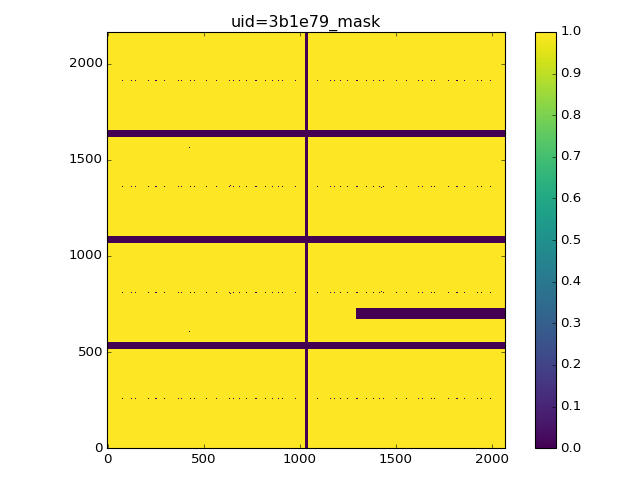

In [148]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= True ) 
mask *= pixel_mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

In [149]:
img_choice_N = 10
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

In [150]:
#show_img( imgsa[1000],  vmin=.1, vmax= 1e1, logs=True, aspect=1,
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )

<IPython.core.display.Javascript object>


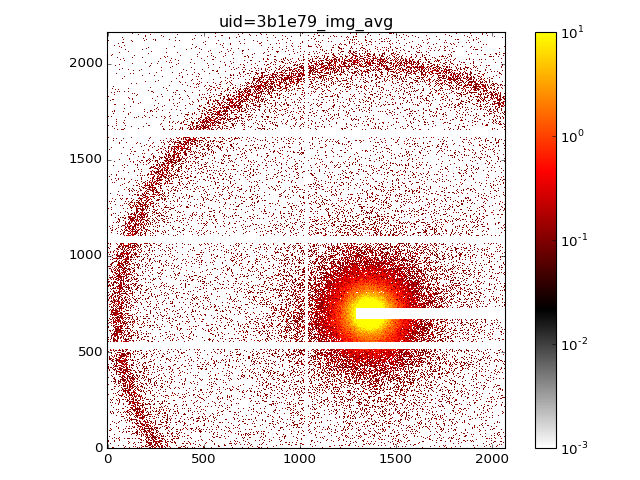

In [151]:
show_img( avg_img,  vmin=.001, vmax= 1e1, logs=True, aspect=1,
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [152]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.19677262583905708.
Will Always DO apply compress process.


In [154]:
good_start = 5  #5  #make the good_start at least 0

In [155]:
bin_frame = False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number=  5
    timeperframe = md['acquire period' ] * bin_frame_number
else:
    bin_frame_number =1

Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_3b1e798d-6668-479e-8e50-cf2810c6d334.cmp.
Using a multiprocess to compress the data.
It will create 10 temporary files for parallel compression.
##########No bad frames are involved.
Combining the seperated compressed files together...
The good_start frame number is: 5 
uid=3b1e79_fra_5_1000


<IPython.core.display.Javascript object>


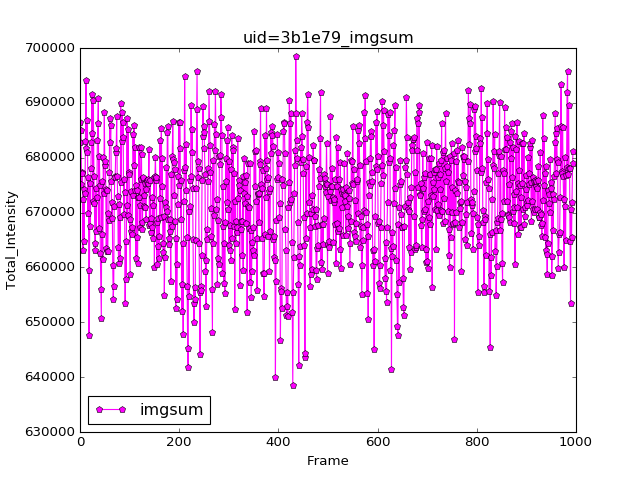

Total time: 24.542 sec


In [156]:
import time
t0= time.time()
if bin_frame_number==1:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
else:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number) 
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold = 1e14,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number

run_time(t0)

<IPython.core.display.Javascript object>


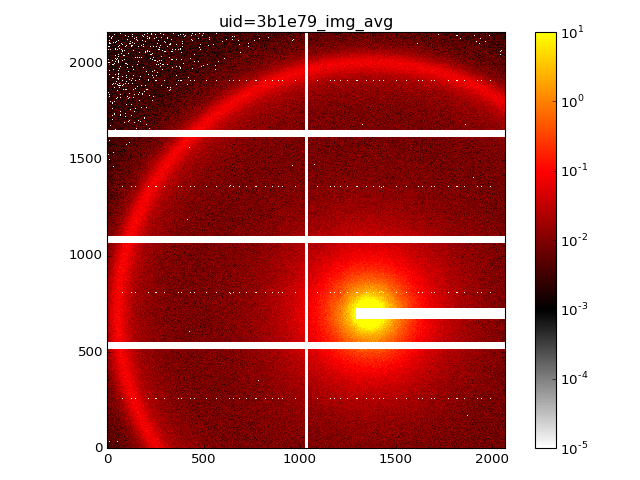

In [157]:
show_img( avg_img ,  vmin=0.00001, vmax= 1e1, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )

## Get bad frame list by a polynominal fit

In [158]:
good_end= None # 2000  
if good_end is not None:
    FD = Multifile(filename, good_start, min( len(imgs)//bin_frame_number, good_end) )
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    

In [159]:
re_define_good_start =False
if re_define_good_start:
    good_start = 10
    good_end = 19700
    FD = Multifile(filename, good_start, good_end) 
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( FD.beg, FD.end)

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


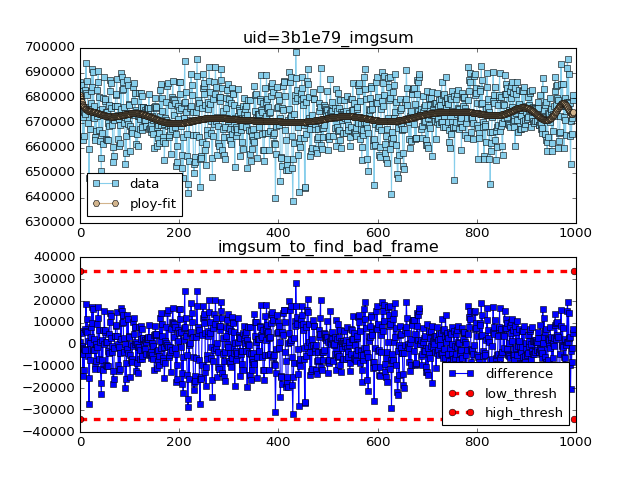

The bad frame list length is: 5


In [160]:
bad_frame_list =  get_bad_frame_list( imgsum, fit='both',  plot=True,polyfit_order = 30,                                      
                        scale=3.5,  good_start = good_start, good_end=good_end, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

### Creat new mask by masking the bad pixels and get new avg_img

In [162]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


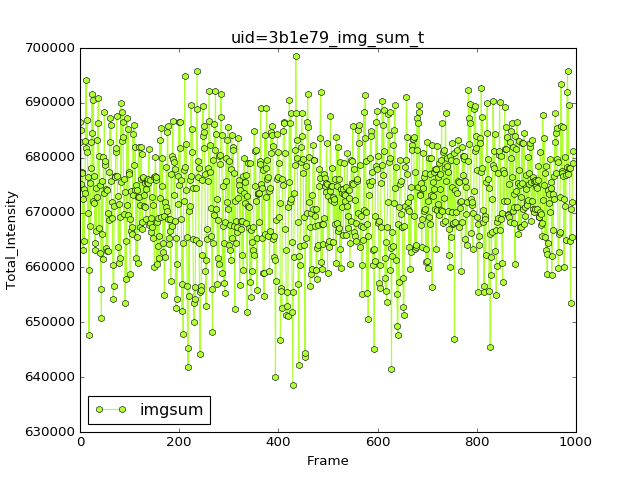

In [163]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

# Load ROI 

In [164]:
fp = path + 'T3SBA15_roi_mask_Jun16_slim.pkl'

fp = path + 'T3SBA15_roi_mask_Jun16.pkl'
#fp = path +'T3SBA15_roi_mask_Jun16_fat.pkl'
roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
print(fp)




if scat_geometry =='gi_saxs':
    
    fp = path + 'XX_roi_masks_June4.pkl'
    roi_masks,qval_dicts = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    print(fp)

    fp = path + 'XX_qmap_June4.pkl'    
    print(fp)
    qr_map, qz_map, ticks, Qrs, Qzs,  Qr, Qz, inc_x0,refl_x0, refl_y0 = cpk.load( open(fp, 'rb' )  )


/XF11ID/analysis/2017_2/masks/T3SBA15_roi_mask_Jun16.pkl


# Static Analysis

## SAXS Scattering Geometry

<IPython.core.display.Javascript object>


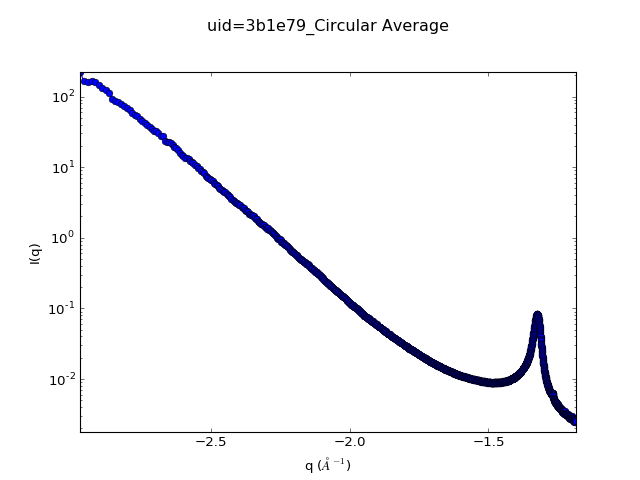

In [165]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 600)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, np.log10(q_saxs),  pargs=setup_pargs, 
                      xlim=[np.log10(q_saxs.min()), np.log10(q_saxs.max()*0.9)], ylim = [iq_saxs.min(), iq_saxs.max()] )
#mask =np.array( mask * hmask, dtype=bool) 


12


<IPython.core.display.Javascript object>


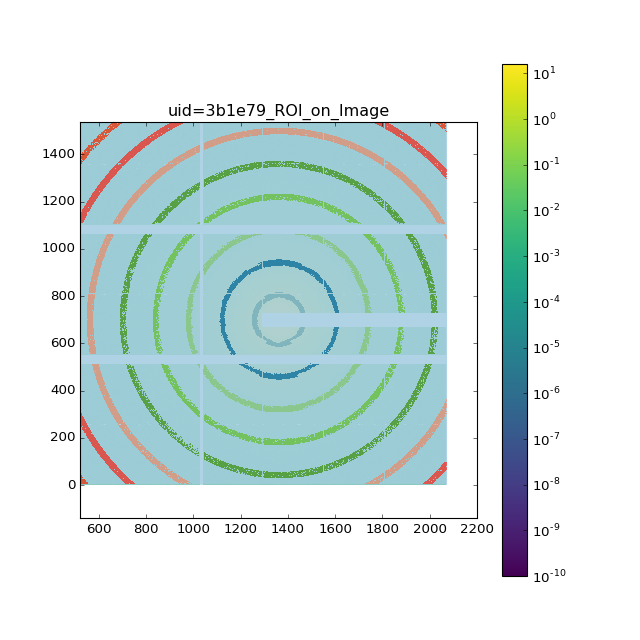

<IPython.core.display.Javascript object>


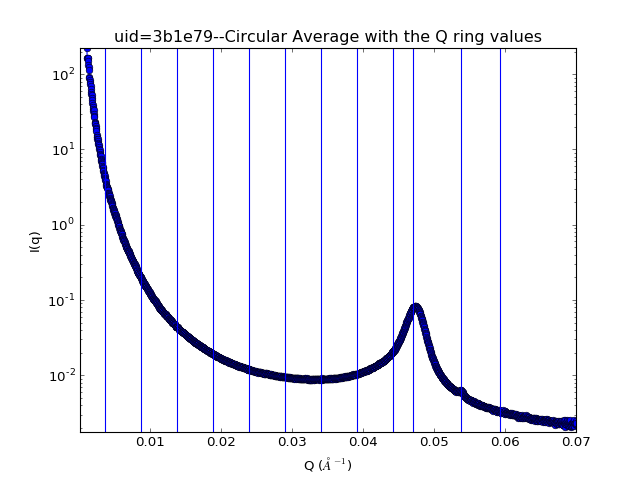

In [166]:
if scat_geometry =='saxs':    
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  
        
    qr = np.array( [qval_dict[k][0] for k in sorted( qval_dict.keys())] )
    print(len(qr))
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth = 840, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img),
                      vmax= 16, #np.max(avg_img),
                     aspect=1) 
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[0.0001,0.07],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

Averaging 1 images: 100%|██████████| 1/1 [00:00<00:00, 173.71it/s]

[[   5    6]
 [ 303  304]
 [ 502  503]
 [ 701  702]
 [ 999 1000]]



Averaging 1 images: 100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


<IPython.core.display.Javascript object>


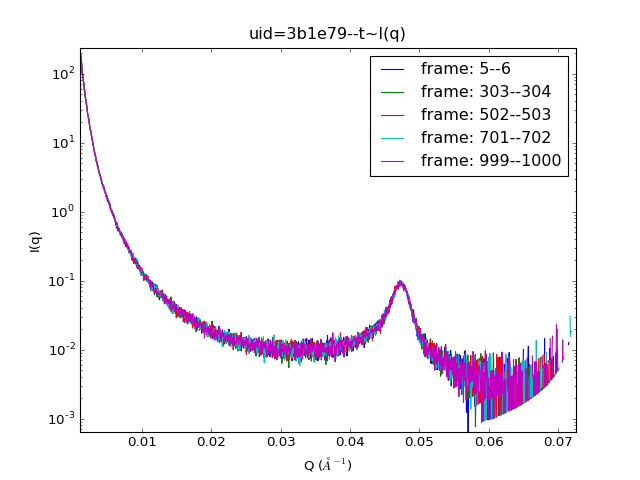

The file: uid=3b1e79_q_Iqt is saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/


In [167]:
if scat_geometry =='saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( Nimg, slice_num= 5, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )
    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

# GiSAXS Scattering Geometry

In [168]:
if scat_geometry =='gi_saxs':    
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [169]:
if scat_geometry =='gi_saxs':
    roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks[:4], alpha=0.5, save=True, path=data_dir, uid=uidstr )

In [170]:
if  scat_geometry =='gi_saxs':    
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 2, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )    
    qrt_pds = get_t_qrc( FD, time_edge, Qrs, Qzs, qr_map, qz_map, path=data_dir, uid = uidstr )    
    plot_qrt_pds( qrt_pds, time_edge, qz_index = 0, uid = uidstr, path =  data_dir )

# Make a Profile Plot

In [171]:
if  scat_geometry =='gi_saxs':
    if run_waterfall:
        xcorners= [ 1100, 1250, 1250, 1100 ]
        ycorners= [ 850, 850, 950, 950 ]   
        waterfall_roi_size = [ xcorners[1] - xcorners[0],  ycorners[2] - ycorners[1]  ]
        waterfall_roi =  create_rectangle_mask(  avg_img, xcorners, ycorners   )
        #show_img( waterfall_roi * avg_img,  aspect=1,vmin=.001, vmax=1, logs=True, )
        wat = cal_waterfallc( FD, waterfall_roi, qindex= 1, bin_waterfall=True,
                              waterfall_roi_size = waterfall_roi_size,save =True, path=data_dir, uid=uidstr)
    

In [172]:
if  scat_geometry =='gi_saxs':
    if run_waterfall:
        plot_waterfallc( wat, qindex=1, aspect=None, vmin=1, vmax= np.max( wat), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

## Dynamic Analysis for gi_saxs

In [173]:
if scat_geometry =='gi_saxs':
       
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks[:4], alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

# GiWAXS Scattering Geometry

In [174]:
if scat_geometry =='gi_waxs':
    badpixel = np.where( avg_img[:600,:] >=300 )
    roi_mask[badpixel] = 0
    show_ROI_on_image( avg_img, roi_mask, label_on = True,  alpha=.5,
                 save=True, path=data_dir, uid=uidstr, vmin=0.1, vmax=5)

* Extract the labeled array

In [175]:
qind, pixelist = roi.extract_label_indices(roi_mask)
noqs = len(np.unique(qind))

* Number of pixels in each q box

In [176]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([11871, 27023, 44697, 66496, 84618, 86938, 70882, 67201, 69579,
       75957, 45266, 17956])

## Check one ROI intensity

<IPython.core.display.Javascript object>


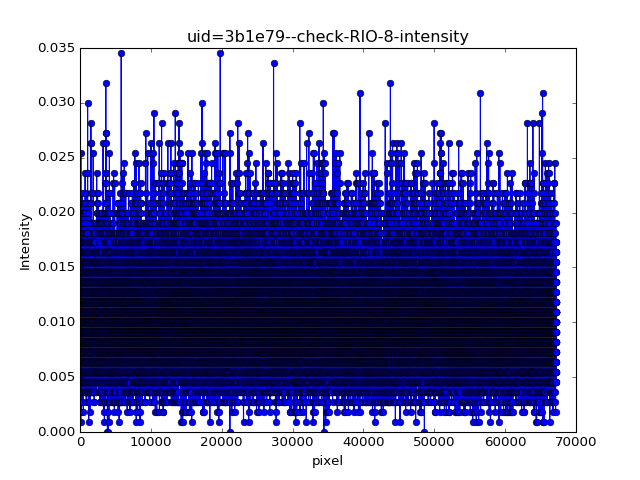

In [177]:
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= 8, uid =uidstr )

## Do a waterfall analysis

In [178]:
qth_interest = 5  #the second ring.
if scat_geometry =='saxs' or scat_geometry =='gi_waxs':
    if run_waterfall:    
        wat = cal_waterfallc( FD, roi_mask, qindex= qth_interest, save =True, path=data_dir, uid=uidstr)

In [179]:
if scat_geometry =='saxs' or scat_geometry =='gi_waxs':
    if run_waterfall: 
        plot_waterfallc( wat, qth_interest, aspect=None, vmax= 10, uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 995/995 [00:02<00:00, 346.87it/s]


<IPython.core.display.Javascript object>


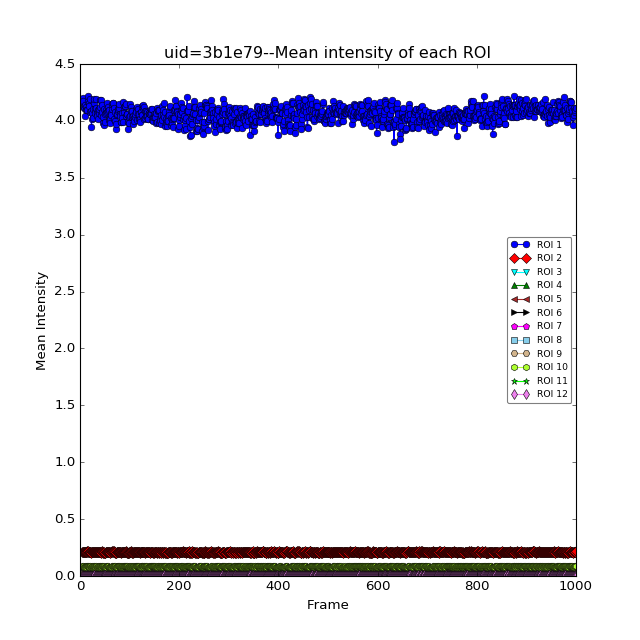

The file: uid=3b1e79_t_ROIs is saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/


In [180]:
ring_avg = None    
if run_t_ROI_Inten:
    times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uidstr, save=True, path=data_dir )
    roi_avg = np.average( mean_int_sets, axis=0)
    

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [181]:
define_good_series = False
#define_good_series = True
if define_good_series:
    good_start = 5
    FD = Multifile(filename, beg = good_start, end =400) # Nimg)#600)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [182]:
if use_sqnorm:norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
else:norm=None 
if use_imgsum_norm:imgsum_ = imgsum
else:imgsum_ = None    
import time

In [183]:
use_imgsum_norm

True

In [184]:
if run_one_time: 
    t0 = time.time()    
    g2, lag_steps  = cal_g2p( FD,  roi_mask, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )
    run_time(t0)
    

In this g2 calculation, the buf and lev number are: 8--9--
5 Bad frames involved and will be discarded!
996 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:17<00:00,  1.45s/it]

G2 calculation DONE!
Total time: 23.927 sec


In [185]:
fit_g2_func

'stretched'

In [186]:
lag_steps = lag_steps[:g2.shape[0]]

In [187]:
if run_one_time: 
    taus = lag_steps * timeperframe    
    g2_pds = save_g2_general( g2, taus=taus,qr=np.array( list( qval_dict.values() ) )[:,0],
                             uid=uid_+'_g2.csv', path= data_dir, return_res=True )

The correlation function is saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/ with filename as uid=3b1e79_fra_5_1000_g2.csv


# Fit g2

In [188]:
if run_one_time:
    g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta': True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.05,'beta': 0.15,'alpha':1.0,'relaxation_rate':.05,},
            guess_limits = dict( baseline =[1, 1.8], alpha=[0, 2],
                        beta = [0, 1], relaxation_rate= [0.001, 5000]) ) 
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid_  +'_g2_fit_paras.csv', path=data_dir ) 
    

The g2 fitting parameters are saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/uid=3b1e79_fra_5_1000_g2_fit_paras.csv


<IPython.core.display.Javascript object>


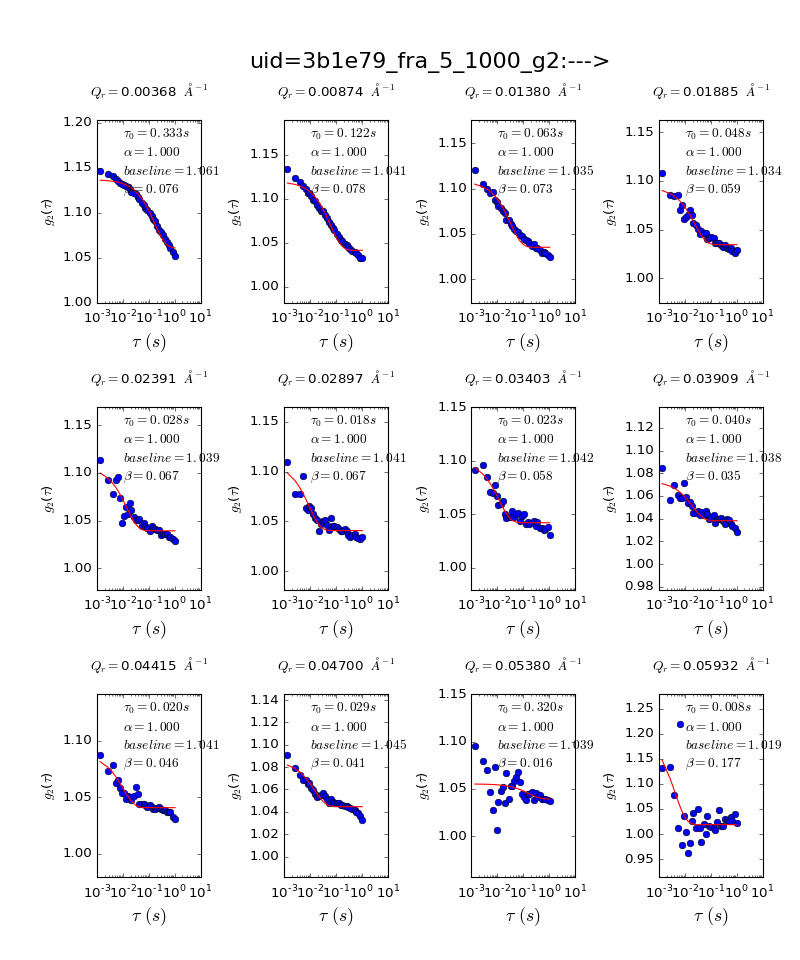

In [189]:
if run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},vlim=[0.95, 1.05],
                qval_dict = qval_dict, fit_res= g2_fit_result,  geometry= scat_geometry,filename= uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')

The fitted diffusion coefficient D0 is:  6.453e+04   A^2S-1


<IPython.core.display.Javascript object>


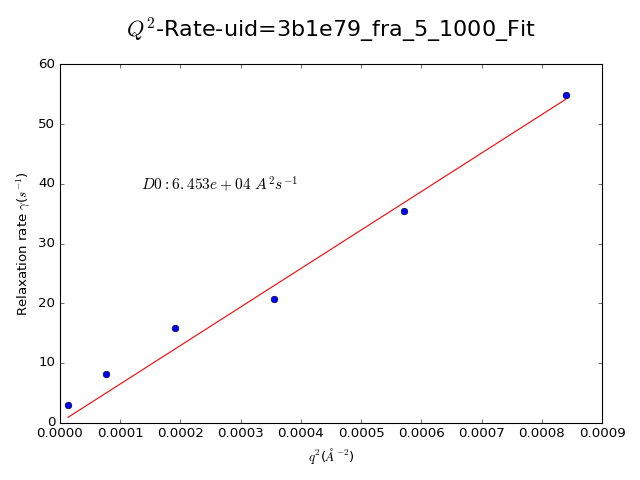

In [191]:
if run_one_time:
    if True:
        fs, fe = 0, 9
        fs,fe=0, 6
        qval_dict_ = {k:qval_dict[k] for k in list(qval_dict.keys())[fs:fe]  }
        D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict_, g2_fit_paras['relaxation_rate'][fs:fe], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict_, g2_fit_paras['relaxation_rate'][fs:fe],  qrate_fit_res, 
                                geometry= scat_geometry,uid=uid_  , path= data_dir )
    else:
        D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'],
                                    fit_range=[0, 16],   geometry= scat_geometry )    
        plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res,   
                            geometry= scat_geometry, uid=uid_  , path= data_dir, plot_all_range=False)

In [ ]:
#plot1D( x= qr, y=g2_fit_paras['beta'], ls='-', m = 'o', c='b', ylabel=r'$\beta$', xlabel=r'$Q( \AA^{-1} ) $' )

# For two-time

In [192]:
define_good_series = False
#define_good_series = True
if define_good_series:
    good_start = 5
    FD = Multifile(filename, beg = good_start, end = 1000)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [193]:
data_pixel = None
if run_two_time:    
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm= norm ).get_data()

100%|██████████| 995/995 [00:11<00:00, 88.28it/s]


In [194]:
import time
t0=time.time()
g12b=None
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  roi_mask, index = None   )
    if run_dose:
        np.save( data_dir + 'uid=%s_g12b'%uid, g12b)
run_time( t0 )  

100%|██████████| 12/12 [00:11<00:00,  1.22it/s]

Total time: 11.575 sec


<IPython.core.display.Javascript object>


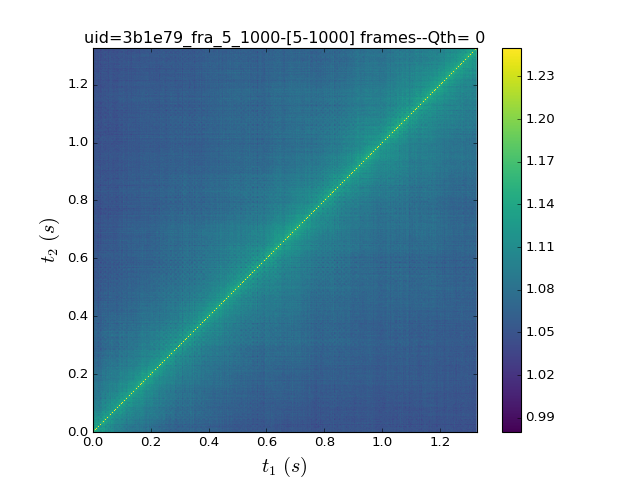

In [195]:
if run_two_time:
    show_C12(g12b, q_ind= 0, N1= FD.beg,logs=False, N2=min( FD.end,5000), vmin= 0.98, vmax=1.25, 
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid_ )    

In [196]:
multi_tau_steps = True
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    #tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    if multi_tau_steps:
        lag_steps_ = lag_steps[   lag_steps <= g12b.shape[0] ]
        g2b = get_one_time_from_two_time(g12b)[lag_steps_]
        tausb = lag_steps_ *timeperframe
    else:
        tausb = (np.arange( g12b.shape[0]) *timeperframe)[:-200]
        g2b = (get_one_time_from_two_time(g12b))[:-200]
    run_time(t0)
         
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:,0],
                              qz=None, uid=uid_ +'_g2b.csv', path= data_dir, return_res=True )
    

Total time: 0.250 sec
The correlation function is saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/ with filename as uid=3b1e79_fra_5_1000_g2b.csv


In [197]:
if run_two_time:
    
    g2b_fit_result, tausb_fit, g2b_fit = get_g2_fit_general( g2b,  tausb, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta': True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.03,'beta': 0.15,'alpha':1.0,'relaxation_rate':.05,},
            guess_limits = dict( baseline =[1, 1.8], alpha=[0, 2],
                        beta = [0, 1], relaxation_rate= [0.001, 5000]) ) 
    g2b_fit_paras = save_g2_fit_para_tocsv(g2b_fit_result,  filename= uid_  +'_g2b_fit_paras.csv', path=data_dir )


The g2 fitting parameters are saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/uid=3b1e79_fra_5_1000_g2b_fit_paras.csv


In [198]:
#plot1D( x = tausb[1:], y =g2b[1:,0], ylim=[0.95, 1.46], xlim = [0.0001, 10], m='', c='r', ls = '-',
#       logx=True, title='one_time_corelation', xlabel = r"$\tau $ $(s)$",    )

<IPython.core.display.Javascript object>


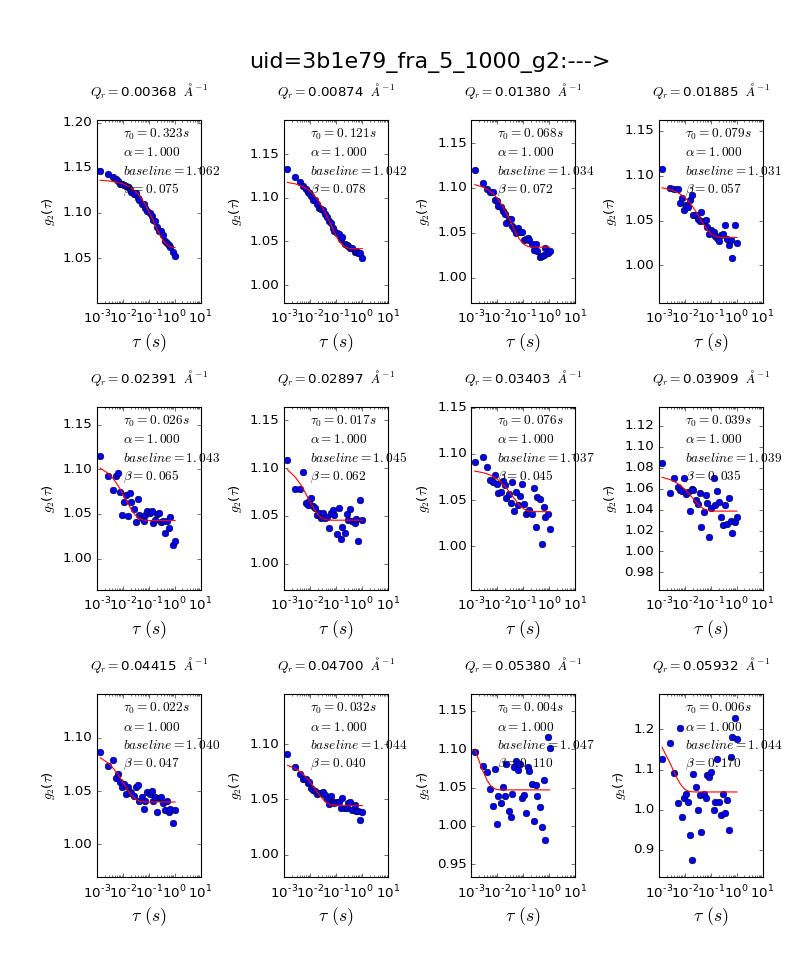

In [199]:
if run_two_time:
    plot_g2_general( g2_dict={1:g2b, 2:g2b_fit}, taus_dict={1:tausb, 2:tausb_fit}, vlim=[0.95, 1.05],
                qval_dict=qval_dict, fit_res= g2b_fit_result,  geometry=scat_geometry,filename=uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')

The fitted diffusion coefficient D0 is:  4.767e+04   A^2S-1


<IPython.core.display.Javascript object>


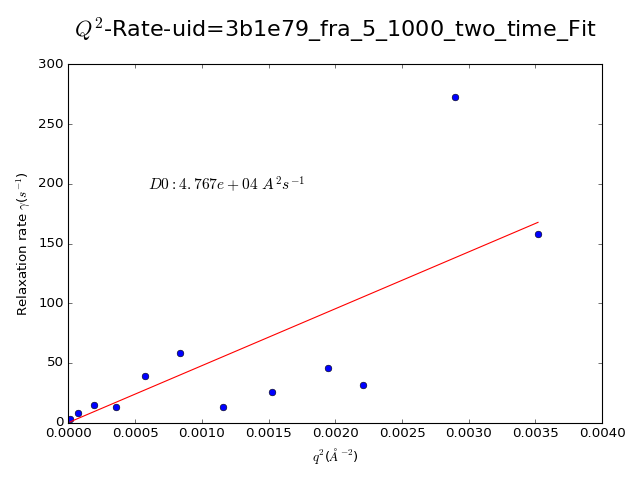

In [200]:
if run_two_time:    
    if True:
        fs, fe = 0,9
        fs, fe = 0,12
        qval_dict_ = {k:qval_dict[k] for k in list(qval_dict.keys())[fs:fe]  }
        D0b, qrate_fit_resb = get_q_rate_fit_general(  qval_dict_, g2b_fit_paras['relaxation_rate'][fs:fe], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict_, g2b_fit_paras['relaxation_rate'][fs:fe],  qrate_fit_resb, 
                            geometry= scat_geometry,uid=uid_ +'_two_time' , path= data_dir )
    else:
    
        D0b, qrate_fit_resb = get_q_rate_fit_general(  qval_dict, g2b_fit_paras['relaxation_rate'],
                                        fit_range=[1, 12],          geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict, g2b_fit_paras['relaxation_rate'],  qrate_fit_resb,   
                            geometry= scat_geometry,uid=uid_ +'_two_time' , path= data_dir, plot_all_range= True )

<IPython.core.display.Javascript object>


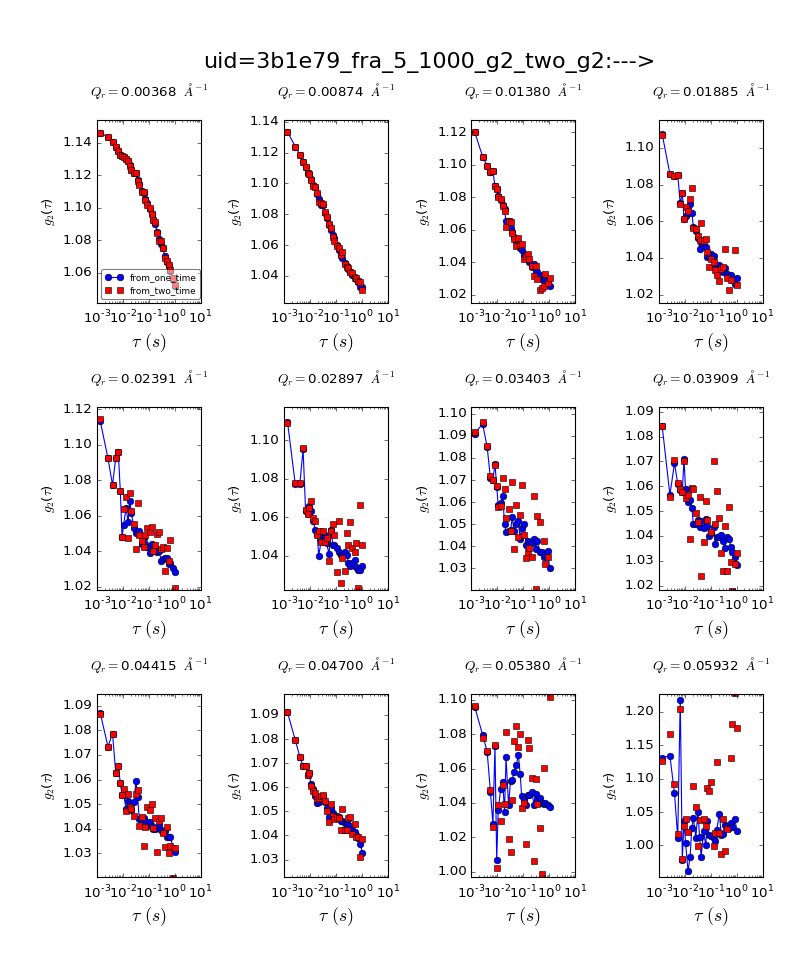

In [201]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.99, 1.007],
                qval_dict=qval_dict, g2_labels=['from_one_time', 'from_two_time'],
            geometry=scat_geometry,filename=uid_+'_g2_two_g2', path= data_dir, ylabel='g2', )

# Run Dose dependent analysis

In [202]:
if run_dose:
    get_two_time_mulit_uids( [uid], roi_mask,  norm= norm,  bin_frame_number=1, 
                        path= data_dir0, force_generate=False )

UID: 3b1e79 is in processing...
The two time correlation function for uid=3b1e79 is already calculated. Just pass...


In [203]:
try:
    print( md['transmission'] )
except:
    md['transmission'] =1

1.0


In [204]:
if run_dose:
    N = len(imgs)
    print(N)
    exposure_dose = md['transmission'] * exposuretime* np.int_([  N/32, N/16, N/8, N/4 ,N/2, 3*N/4, N*0.99 ])
    print( exposure_dose )

1000
[ 0.04123  0.08246  0.16625  0.3325   0.665    0.9975   1.3167 ]


In [205]:
if run_dose:
    taus_uids, g2_uids = get_series_one_time_mulit_uids( [ uid ],  qval_dict, good_start=good_start,  
                    path= data_dir0, exposure_dose = exposure_dose,  num_bufs =8, save_g2= False,
                                                   dead_time = 0, trans = [ md['transmission'] ] )

UID: 3b1e79 is in processing...
uid: 3b1e79--> fra_num_by_dose: [ 31  62 125 250 500 750 990]


<IPython.core.display.Javascript object>


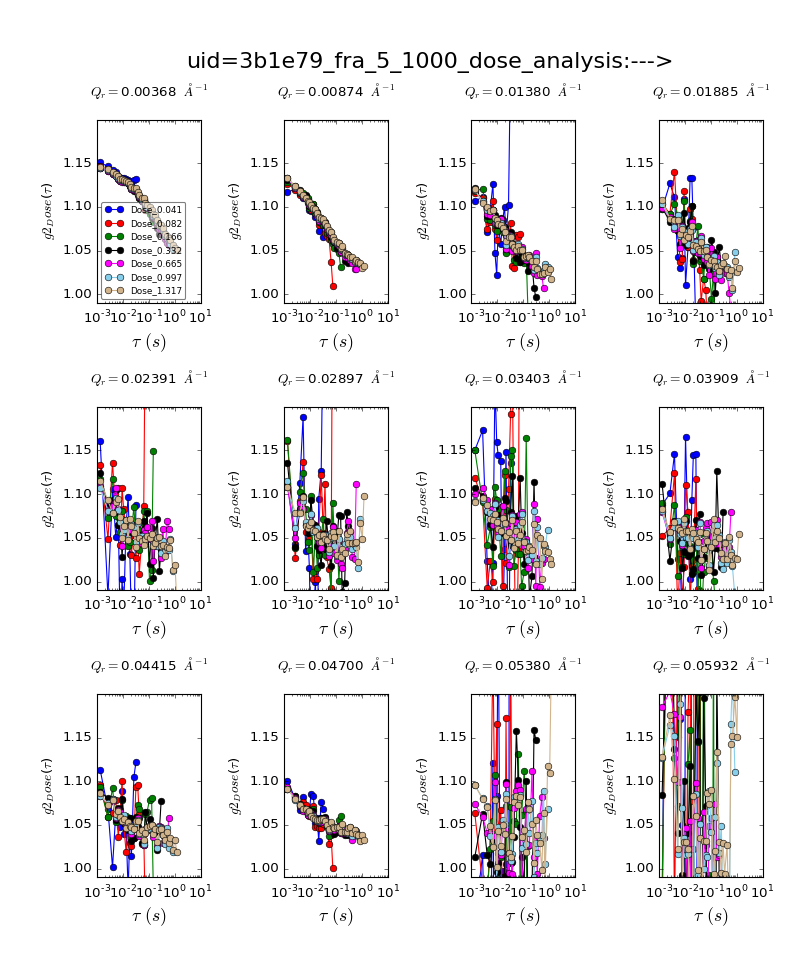

In [206]:
if run_dose:    
    plot_dose_g2( taus_uids, g2_uids, ylim=[0.99, 1.2], vshift= 0.00,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry,
                 filename= '%s_dose_analysis'%uid_, 
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

<IPython.core.display.Javascript object>


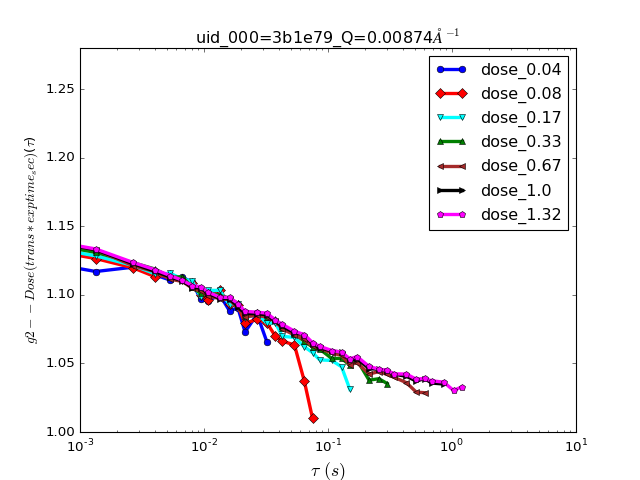

In [207]:
if run_dose:
    qth_interest = 1
    plot_dose_g2( taus_uids, g2_uids, qth_interest= qth_interest, ylim=[1.0, 1.28], vshift= 0.00,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry,
                 filename= '%s_dose_analysis'%uidstr, 
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

# Four Time Correlation

In [208]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

In [209]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                             qz=None, uid=uid_ +'_g4.csv', path= data_dir, return_res=True )

In [210]:
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                geometry=scat_geometry,filename=uid_+'_g4',path= data_dir,   ylabel='g4')

# Speckle Visiblity

In [211]:
#run_xsvs =True

In [212]:
if run_xsvs:    
    max_cts = get_max_countc(FD, roi_mask )    
    max_cts = 15 #for eiger 500 K
    qind, pixelist = roi.extract_label_indices(   roi_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    #time_steps = np.array( utils.geometric_series(2,   len(imgs)   ) )
    time_steps = [0,1]  #only run the first two levels
    num_times = len(time_steps)    
    times_xsvs = exposuretime + (2**(  np.arange( len(time_steps) ) ) -1 ) * timeperframe   
    print( 'The max counts are: %s'%max_cts )


### Do historam 

In [213]:
if run_xsvs:
    if roi_avg is  None:
        times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
        roi_avg = np.average( mean_int_sets, axis=0)
    
    t0=time.time()
    spec_bins, spec_his, spec_std  =  xsvsp( FD, np.int_(roi_mask), norm=None,
                max_cts=int(max_cts+2),  bad_images=bad_frame_list, only_two_levels=True )    
    spec_kmean =  np.array(  [roi_avg * 2**j for j in  range( spec_his.shape[0] )] )
    run_time(t0)
    spec_pds =  save_bin_his_std( spec_bins, spec_his, spec_std, filename=uid_+'_spec_res.csv', path=data_dir ) 

### Do historam fit by negtive binominal function with maximum likehood method

In [214]:
if run_xsvs:    
    ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_kmean,  spec_std, max_bins=2, varyK= False ) #True  )
    #print( 'The observed average photon counts are: %s'%np.round(K_mean,4))
    #print( 'The fitted average photon counts are: %s'%np.round(K_,4)) 
    print( 'The difference sum of average photon counts between fit and data are: %s'%np.round( 
            abs(np.sum( spec_kmean[0,:] - K_ )),4))
    print( '#'*30)
    qth=   0 
    print( 'The fitted M for Qth= %s are: %s'%(qth, ML_val[qth]) )
    print( K_[qth])
    print( '#'*30)

## Plot fit results

In [215]:
if run_xsvs:   
    qr = [qval_dict[k][0] for k in list(qval_dict.keys()) ]
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std=spec_std,
                  xlim = [0,10], vlim =[.9, 1.1],
        uid=uid_, qth= qth_interest, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir)
    
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,
                  xlim = [0,15], vlim =[.9, 1.1],
        uid=uid_, qth= None, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir )

### Get contrast

In [216]:
if run_xsvs:
    contrast_factorL = get_contrast( ML_val)
    spec_km_pds = save_KM(  spec_kmean, KL_val, ML_val, qs=qr, level_time=times_xsvs, uid=uid_, path = data_dir )
    #spec_km_pds

### Plot contrast with g2 restuls

In [217]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2b, times_xsvs, tausb, qr, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_,path = data_dir, legend_size=14)

    plot_g2_contrast( contrast_factorL, g2b, times_xsvs, tausb, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid_,path = data_dir, legend_size=4)

In [218]:
#from chxanalys.chx_libs import cmap_vge, cmap_albula, Javascript

# Export Results to a HDF5 File

In [219]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] =  data_dir + get_current_pipeline_fullpath(NFP).split('/')[-1]
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['roi_mask'] = roi_mask
md['setup_pargs'] = setup_pargs
if scat_geometry == 'gi_saxs':        
    md['Qr'] = Qr
    md['Qz'] = Qz
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  inc_x0
    md['beam_center_y']=   inc_y0
    md['beam_refl_center_x'] = refl_x0
    md['beam_refl_center_y'] = refl_y0

elif scat_geometry == 'gi_waxs':
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]
else:
    md['qr']= qr
    #md['qr_edge'] = qr_edge
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]            

md['beg'] = FD.beg
md['end'] = FD.end
md['qth_interest'] = qth_interest
md['metadata_file'] = data_dir + 'uid=%s_md.pkl'%uid
psave_obj(  md, data_dir + 'uid=%s_md.pkl'%uid ) #save the setup parameters'372d72'# (scan num: 23789) (Measurement: T3 SBA15 in cryostat xpcs -1000frames acq=0.5s exp=0.1s att .01 )
save_dict_csv( md,  data_dir + 'uid=%s_md.csv'%uid, 'w')

Exdt = {} 
if scat_geometry == 'gi_saxs':

    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list', 'qr_1d_pds'], 
                [md,    roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list, qr_1d_pds] ):
        Exdt[ k ] = v
elif scat_geometry == 'saxs': 
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v
elif scat_geometry == 'gi_waxs': 
    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md,       roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v
        
if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
    #for k,v in zip( ['tausb','g2b','g2b_fit_paras', ], [tausb,g2b,g2b_fit_paras] ):Exdt[ k ] = v    
if run_dose:
    for k,v in zip( [ 'taus_uids', 'g2_uids' ], [taus_uids, g2_uids] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['spec_kmean','spec_pds','times_xsvs','spec_km_pds','contrast_factorL'], 
                   [ spec_kmean,spec_pds,times_xsvs,spec_km_pds,contrast_factorL] ):Exdt[ k ] = v 

In [220]:
#%run chxanalys_link/chxanalys/Create_Report.py

In [221]:
export_xpcs_results_to_h5( 'uid=%s_Res.h5'%md['uid'], data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2017_2/sutton/Results/3b1e79/ with filename as uid=3b1e798d-6668-479e-8e50-cf2810c6d334_Res.h5


In [222]:
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

# Create PDF Report

In [223]:
#pdf_version='_@Mar24_2'     #for pdf report name

In [224]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)

In [225]:
#%run chxanalys_link/chxanalys/Create_Report.py

In [226]:
make_pdf_report( data_dir, uid, pdf_out_dir, pdf_filename, username, 
                    run_fit_form,run_one_time, run_two_time, run_four_time, run_xsvs, run_dose,
                report_type= scat_geometry, 
               md = md )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2017_2/sutton/Results/XPCS_Analysis_Report_for_uid=3b1e79_June17.pdf
****************************************


## Attach the PDF report to Olog 

In [227]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= md['uid'], text='Add XPCS Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

I can't attach this PDF: /XF11ID/analysis/2017_2/sutton/Results/XPCS_Analysis_Report_for_uid=3b1e79_June17.pdf due to a duplicated filename. Please give a different PDF file.


# 

In [228]:
uid

'3b1e79'

# Save the current pipeline in Results folder

In [229]:
save_current_pipelines = True

In [230]:
if save_current_pipelines:
    save_current_pipeline( NFP, data_dir)
    get_current_pipeline_fullpath(NFP)

This pipeline: XPCS_Single_2017_V4_template.ipynb is saved in /XF11ID/analysis/2017_2/sutton/Results/3b1e79/.


# The End!